# Tensorflow time series 

In this notebook we are going to build a recurrent neural network in order to get a predict next occuring digit of a binary digits.

### Import Libraries 

In this section we are going to import required libraries for our project 

In [1]:
# tensorflow import
import tensorflow as tf

# helper library 
import numpy as np # matrix maths 
from __future__ import print_function, division # to cover difference between 2.7 and 3.x
import time # for time operations

# viz imports
import matplotlib.pyplot as plt # for making plots 

%matplotlib inline

### Hyperparameter 

In this section we are going to perform a hyper parameter optimization in order to tune model. 

In [2]:
NUM_EPOCHS = 100 # num of iterarions 
TOTAL_SERIES_LENGTH = 50000 # total length of series
TRUNCATED_BACKPROP_LENGTH = 15 # states to save till memory
STATE_SIZE = 4 # size of state 
NUM_CLASSES = 2 # num of classes to classify
ECHO_STEP = 3 # num steps ahead of original series 
BATCH_SIZE = 5 # size of a batch process
NUM_BATCHES = TOTAL_SERIES_LENGTH // BATCH_SIZE // TRUNCATED_BACKPROP_LENGTH # num of such batches in series

### Generate Data 

In this section we are going to generate data set for our RNN in form of binary digits

In [3]:
# gen data function 
def generateData():
    """A function that generates 50K data samples for our model"""
    
    # generating random seed of data for x label 
    np.random.seed(1) 
    x = np.array(np.random.choice(2, TOTAL_SERIES_LENGTH, p = [0.5, 0.5]))
    
    # shifting series to 3 places for output 
    y = np.roll(x, ECHO_STEP)
    y[:ECHO_STEP] = 0 # setting inital places of y series to 0
    
    # reshape array for 5,1 size
    x = np.reshape(x, [BATCH_SIZE, -1])
    y = np.reshape(y, [BATCH_SIZE, -1])
    
    
    # return data set 
    return (x, y)

# showing data 
data = generateData()
print("Data \n {}".format(data))
print("Shape of Series {}".format(data[0].shape))

Data 
 (array([[0, 1, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 0, 1]]), array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 1, 1, ..., 0, 1, 0],
       [1, 1, 0, ..., 1, 0, 0]]))
Shape of Series (5, 10000)


### Build the model 

In this section we are going to build our model for computation 

In [4]:
#datatype, shape (5, 15) 2D array or matrix, batch size shape for later
batchX_placeholder = tf.placeholder(tf.float32, [BATCH_SIZE, TRUNCATED_BACKPROP_LENGTH])
batchY_placeholder = tf.placeholder(tf.int32, [BATCH_SIZE, TRUNCATED_BACKPROP_LENGTH])

#and one for the RNN state, 5,4 
init_state = tf.placeholder(tf.float32, [BATCH_SIZE, STATE_SIZE])
init_state = tf.placeholder(tf.float32, [BATCH_SIZE, STATE_SIZE])

In [5]:
# recurrent network layer 

# three layers of RNN, one hidden layer 
W = tf.Variable(np.random.rand(BATCH_SIZE, STATE_SIZE), dtype=tf.float32)
# baises for layer 
b = tf.Variable(tf.zeros((1, STATE_SIZE)), dtype=tf.float32)

# weights and biases for layer 2
W2 = tf.Variable(np.random.rand(STATE_SIZE, NUM_CLASSES), dtype=tf.float32)
b2 = tf.Variable(tf.zeros((1, NUM_CLASSES)), dtype=tf.float32)

In [6]:
# unpack the series in order to make it of one d 
input_series = tf.unstack(batchX_placeholder, axis=1)
label_series = tf.unstack(batchY_placeholder, axis=1)

### Forward pass

In [7]:
current_state = init_state
#series of states through time
states_series = []


#for each set of inputs
#forward pass through the network to get new state value
#store all states in memory
for current_input in input_series:
    #format input
    current_input = tf.reshape(current_input, [BATCH_SIZE, 1])
    #mix both state and input data 
    input_and_state_concatenated = tf.concat([current_input, current_state], axis=1)  # Increasing number of columns
    #perform matrix multiplication between weights and input, add bias
    #squash with a nonlinearity, for probabiolity value
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    #store the state in memory
    states_series.append(next_state)
    #set current state to next one
    current_state = next_state

In [8]:
#calculate loss
#second part of forward pass
#logits short for logistic transform
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
#apply softmax nonlinearity for output probability
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

#measure loss, calculate softmax again on logits, then compute cross entropy
#measures the difference between two probability distributions
#this will return A Tensor of the same shape as labels and of the same type as logits 
#with the softmax cross entropy loss.
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,label_series)]
#computes average, one value
total_loss = tf.reduce_mean(losses)
#use adagrad to minimize with .3 learning rate
#minimize it with adagrad, not SGD
#One downside of SGD is that it is sensitive to
#the learning rate hyper-parameter. When the data are sparse and features have
#different frequencies, a single learning rate for every weight update can have
#exponential regret.
#Some features can be extremely useful and informative to an optimization problem but 
#they may not show up in most of the training instances or data. If, when they do show up, 
#they are weighted equally in terms of learning rate as a feature that has shown up hundreds 
#of times we are practically saying that the influence of such features means nothing in the 
#overall optimization. it's impact per step in the stochastic gradient descent will be so small 
#that it can practically be discounted). To counter this, AdaGrad makes it such that features 
#that are more sparse in the data have a higher learning rate which translates into a larger 
#update for that feature
#sparse features can be very useful.
#Each feature has a different learning rate which is adaptable. 
#gives voice to the little guy who matters a lot
#weights that receive high gradients will have their effective learning rate reduced, 
#while weights that receive small or infrequent updates will have their effective learning rate increased. 
#great paper http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

### Plot function 

This section contains a function for plotting our model

In [9]:
#visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, TRUNCATED_BACKPROP_LENGTH, 0, 2])
        left_offset = range(TRUNCATED_BACKPROP_LENGTH)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

### Training our network 

in this section we are going to train our network

<Figure size 432x288 with 0 Axes>

New Data epoch  0
Step 0 Loss 0.9379354 Time Taken 0.354984998703


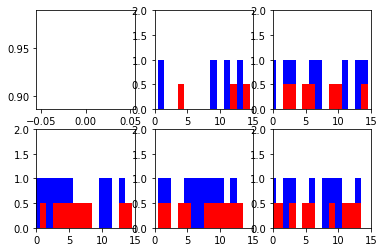

Step 100 Loss 0.6885645 Time Taken 2.17431783676


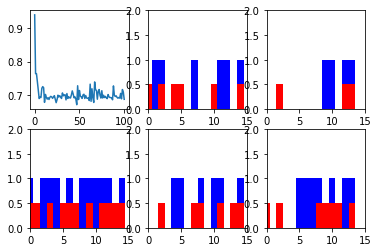

Step 200 Loss 0.6992562 Time Taken 3.95204997063


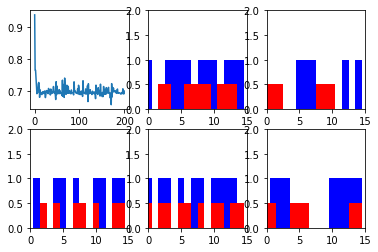

Step 300 Loss 0.6915826 Time Taken 5.77663493156


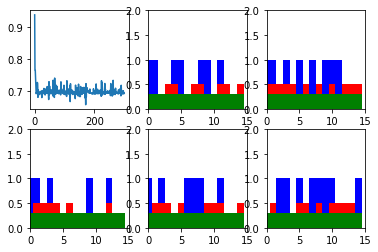

Step 400 Loss 0.69351095 Time Taken 7.74953484535


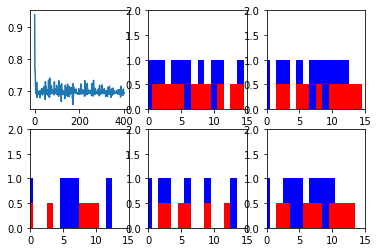

Step 500 Loss 0.7003675 Time Taken 9.74154305458


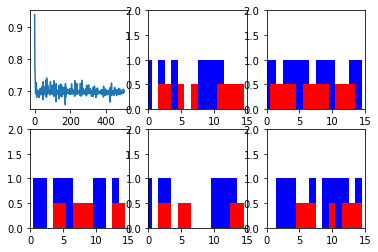

Step 600 Loss 0.6819819 Time Taken 11.5428378582


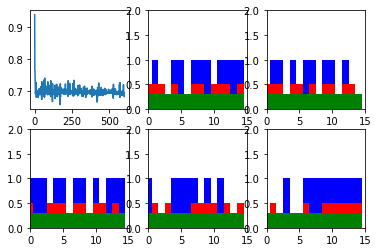

New Data epoch  1
Step 0 Loss 0.7255336 Time Taken 0.00270295143127


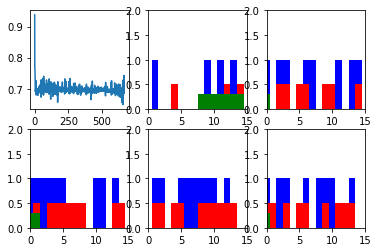

Step 100 Loss 0.64212334 Time Taken 1.71224498749


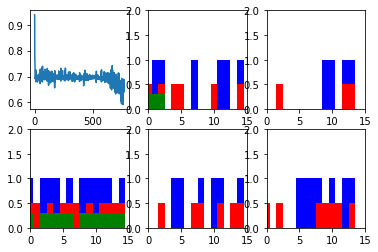

Step 200 Loss 0.6459373 Time Taken 3.55189299583


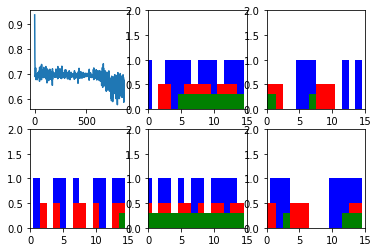

Step 300 Loss 0.5283525 Time Taken 5.12311697006


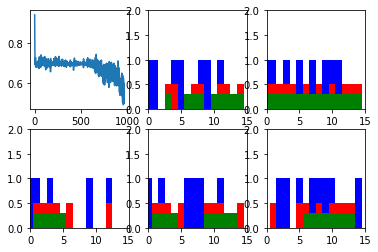

Step 400 Loss 0.32165015 Time Taken 6.49148893356


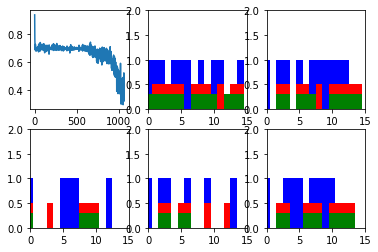

Step 500 Loss 0.28567874 Time Taken 7.96354389191


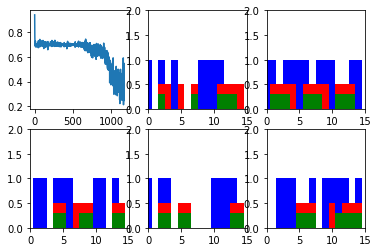

Step 600 Loss 0.3875447 Time Taken 9.38764476776


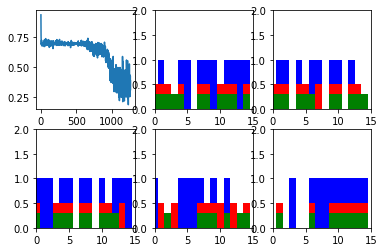

New Data epoch  2
Step 0 Loss 0.1892302 Time Taken 0.00296092033386


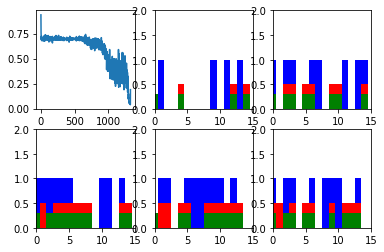

Step 100 Loss 0.020018728 Time Taken 1.69523096085


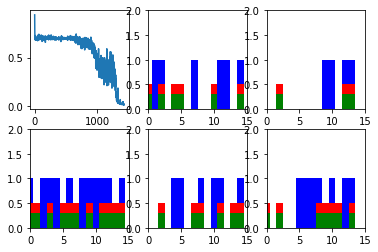

Step 200 Loss 0.014069096 Time Taken 3.36656403542


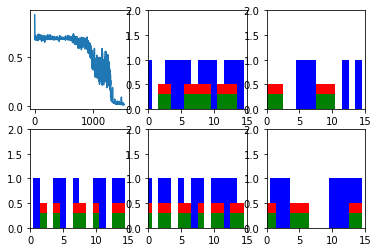

Step 300 Loss 0.0114006875 Time Taken 4.94092798233


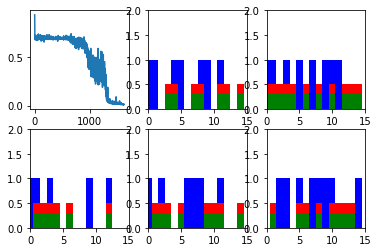

Step 400 Loss 0.012956252 Time Taken 6.68141913414


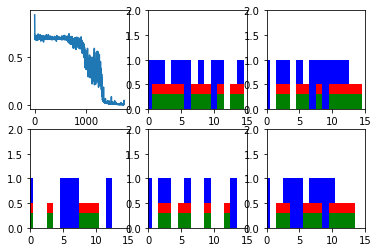

Step 500 Loss 0.0075458707 Time Taken 8.04598712921


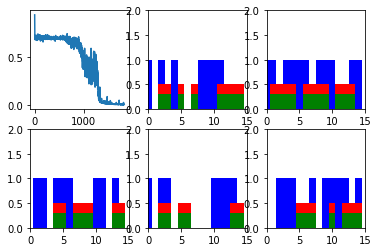

Step 600 Loss 0.005136381 Time Taken 9.61010408401


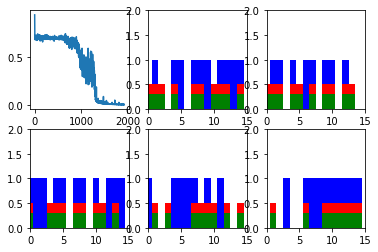

New Data epoch  3
Step 0 Loss 0.15471013 Time Taken 0.00250005722046


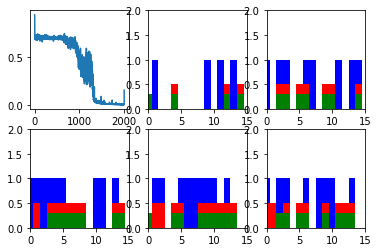

Step 100 Loss 0.0041454537 Time Taken 1.45370292664


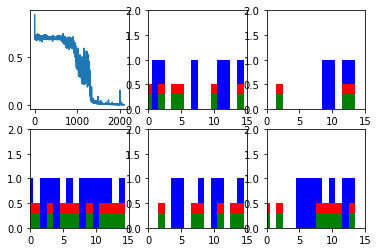

Step 200 Loss 0.004519585 Time Taken 2.94803595543


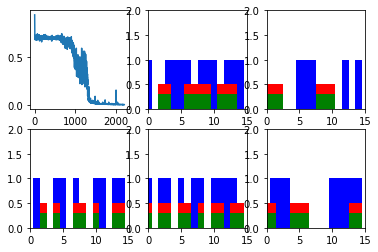

Step 300 Loss 0.0049817623 Time Taken 4.46430301666


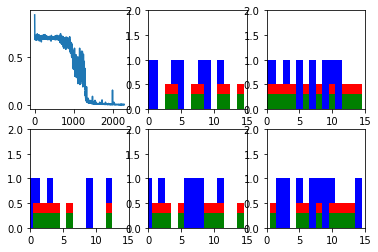

Step 400 Loss 0.0030966362 Time Taken 6.00232195854


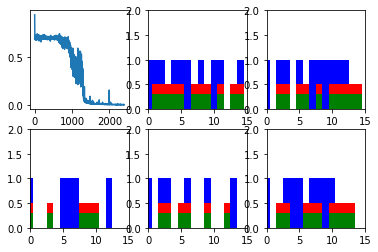

Step 500 Loss 0.0033117824 Time Taken 7.72103309631


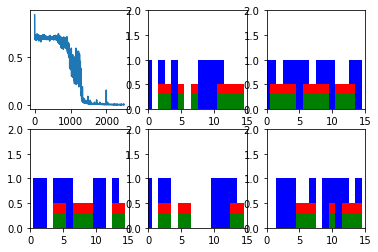

Step 600 Loss 0.0026520712 Time Taken 9.31745505333


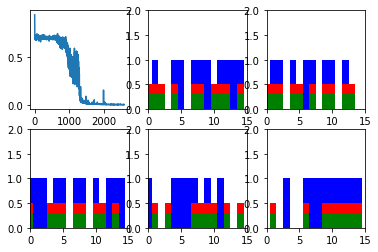

New Data epoch  4
Step 0 Loss 0.15557228 Time Taken 0.00191307067871


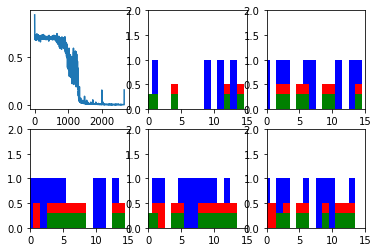

Step 100 Loss 0.0022181899 Time Taken 1.42702698708


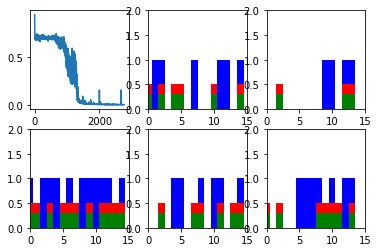

Step 200 Loss 0.002525551 Time Taken 2.73388814926


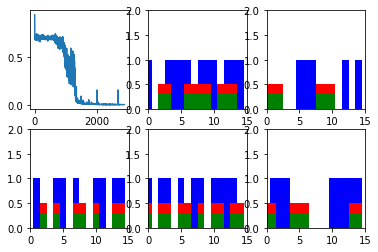

Step 300 Loss 0.0025949231 Time Taken 4.22909212112


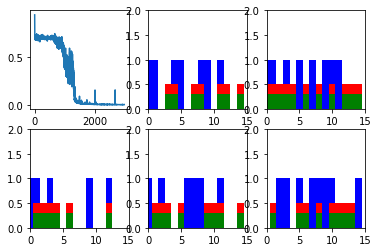

Step 400 Loss 0.0019082798 Time Taken 5.65665602684


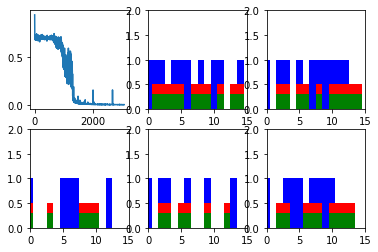

Step 500 Loss 0.002073913 Time Taken 7.13897204399


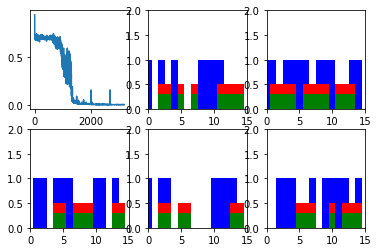

Step 600 Loss 0.0018422568 Time Taken 8.74658513069


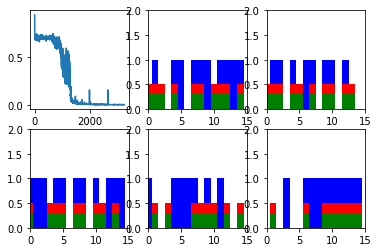

New Data epoch  5
Step 0 Loss 0.1519966 Time Taken 0.00207901000977


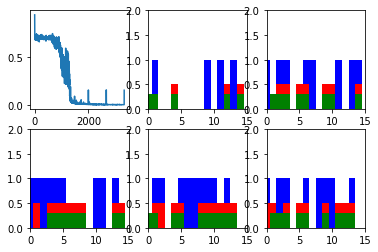

Step 100 Loss 0.0014651844 Time Taken 1.32214093208


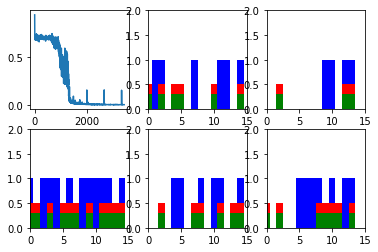

Step 200 Loss 0.00172259 Time Taken 2.7209508419


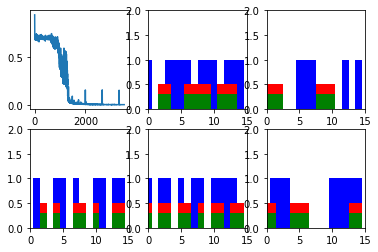

Step 300 Loss 0.0016065135 Time Taken 4.21407580376


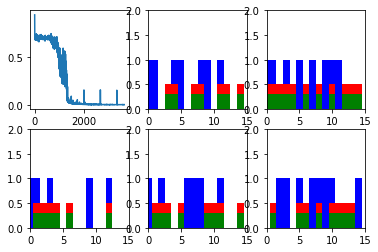

Step 400 Loss 0.0013666399 Time Taken 5.51420378685


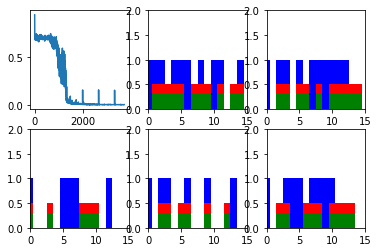

Step 500 Loss 0.0015122065 Time Taken 6.91459393501


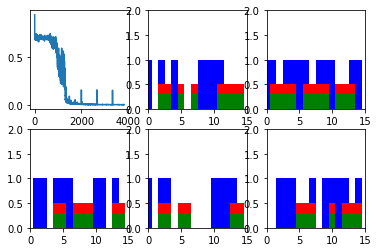

Step 600 Loss 0.0013462354 Time Taken 8.21815085411


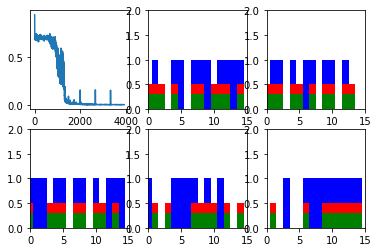

New Data epoch  6
Step 0 Loss 0.15135483 Time Taken 0.00196385383606


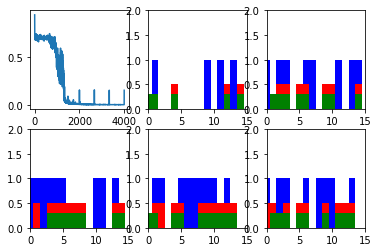

Step 100 Loss 0.0010847775 Time Taken 1.58952784538


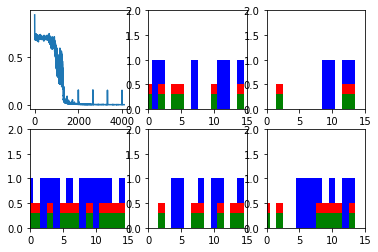

Step 200 Loss 0.0012923651 Time Taken 2.89461398125


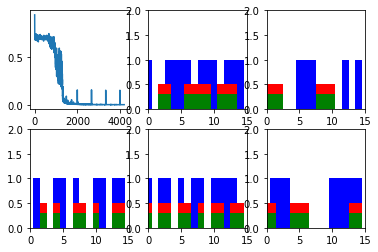

Step 300 Loss 0.0011975382 Time Taken 4.49750900269


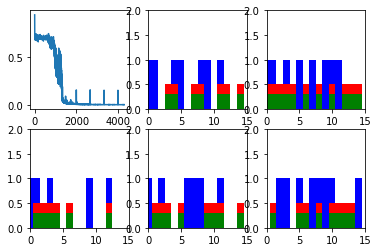

Step 400 Loss 0.0010615208 Time Taken 5.7938978672


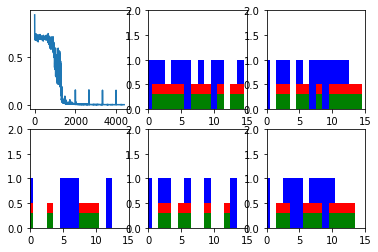

Step 500 Loss 0.0011977683 Time Taken 7.29426884651


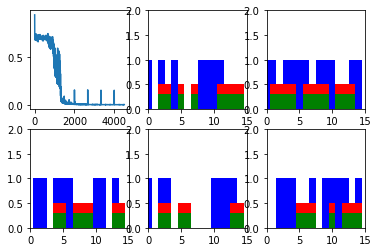

Step 600 Loss 0.0010151432 Time Taken 8.73503994942


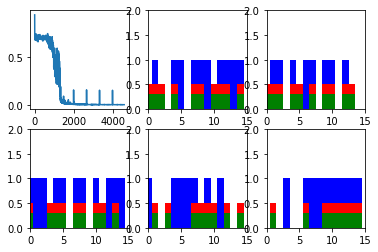

New Data epoch  7
Step 0 Loss 0.15061417 Time Taken 0.00189590454102


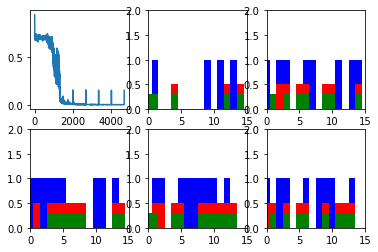

Step 100 Loss 0.0008623926 Time Taken 1.33294701576


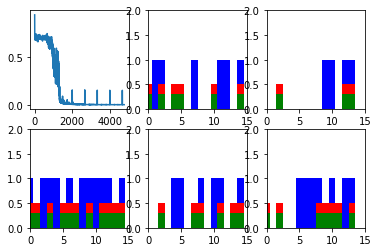

Step 200 Loss 0.0010239951 Time Taken 2.73397397995


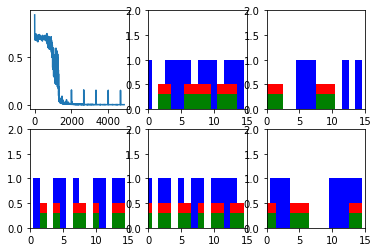

Step 300 Loss 0.00096732995 Time Taken 4.03707385063


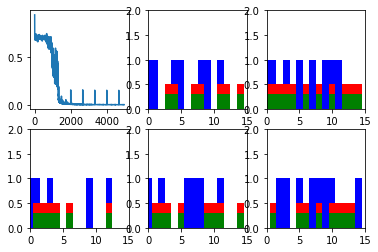

Step 400 Loss 0.00086437754 Time Taken 5.50155091286


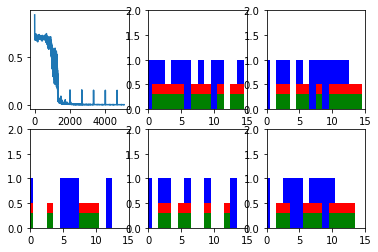

Step 500 Loss 0.0009932901 Time Taken 6.91217303276


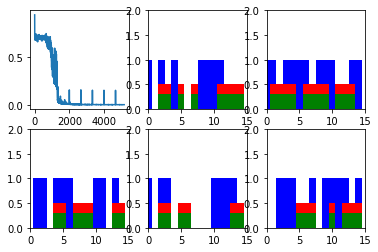

Step 600 Loss 0.00082343107 Time Taken 8.33833193779


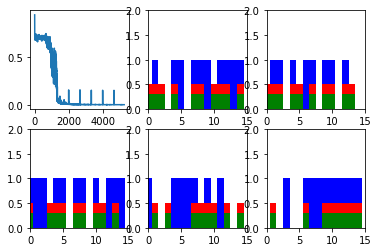

New Data epoch  8
Step 0 Loss 0.149435 Time Taken 0.00177407264709


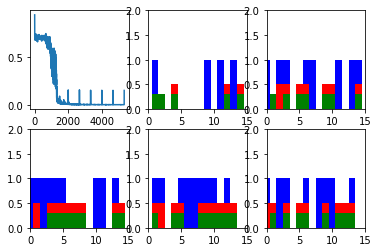

Step 100 Loss 0.0007167088 Time Taken 1.38650393486


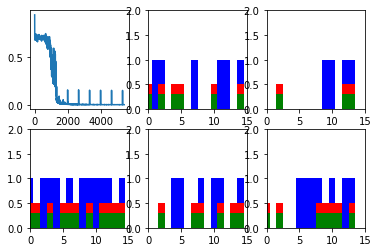

Step 200 Loss 0.00084023195 Time Taken 2.98390507698


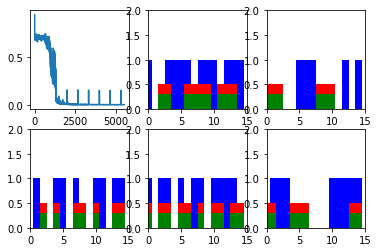

Step 300 Loss 0.00081406924 Time Taken 4.69706702232


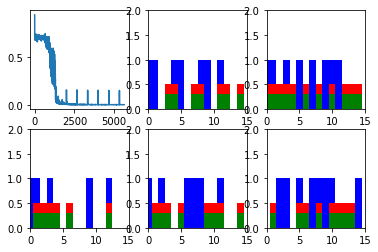

Step 400 Loss 0.0007264299 Time Taken 6.2884221077


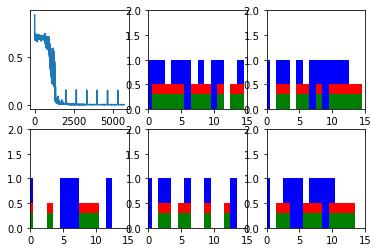

Step 500 Loss 0.00084874115 Time Taken 7.74853801727


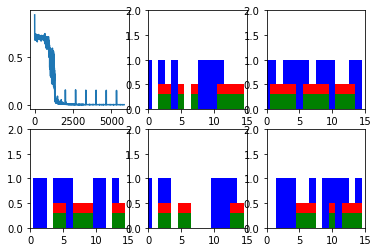

Step 600 Loss 0.00069864554 Time Taken 9.39944696426


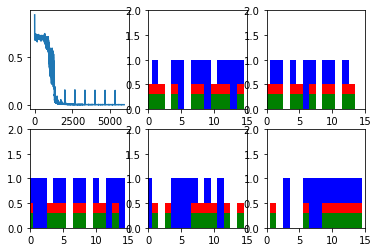

New Data epoch  9
Step 0 Loss 0.14800176 Time Taken 0.00217700004578


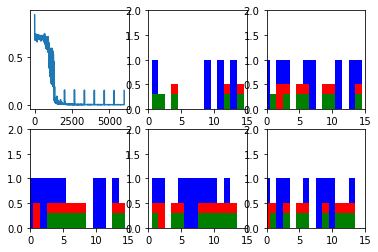

Step 100 Loss 0.00061439077 Time Taken 1.61854982376


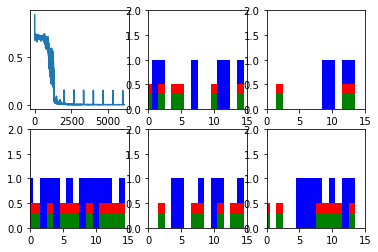

Step 200 Loss 0.0007091865 Time Taken 3.0734307766


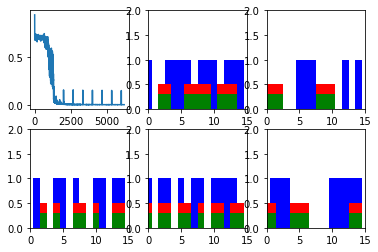

Step 300 Loss 0.000703446 Time Taken 4.38416194916


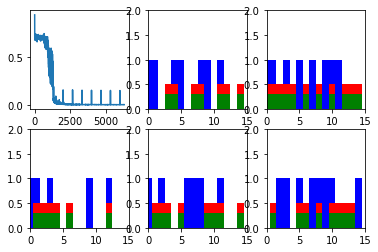

Step 400 Loss 0.0006250539 Time Taken 6.08776783943


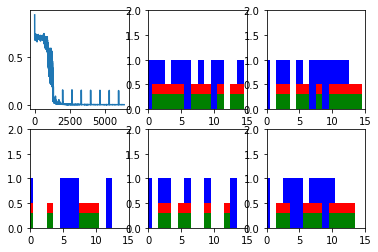

Step 500 Loss 0.00074106816 Time Taken 7.67436289787


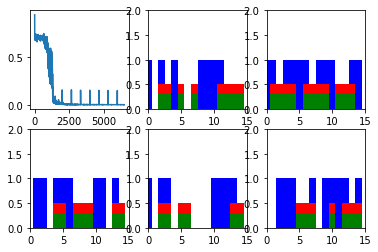

Step 600 Loss 0.0006083562 Time Taken 9.24134492874


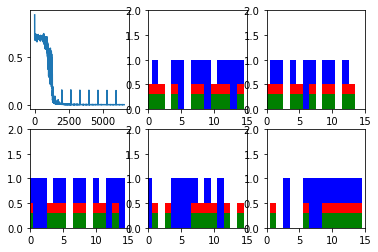

New Data epoch  10
Step 0 Loss 0.14642555 Time Taken 0.00211095809937


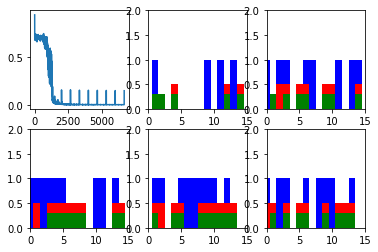

Step 100 Loss 0.00053846004 Time Taken 1.57340097427


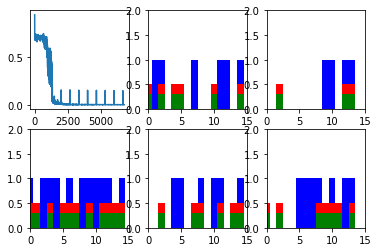

Step 200 Loss 0.00061271817 Time Taken 3.15830087662


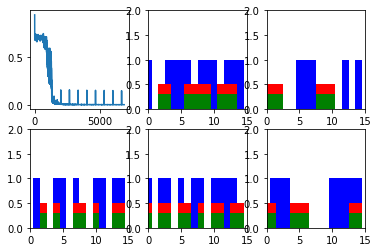

Step 300 Loss 0.0006196259 Time Taken 4.68950200081


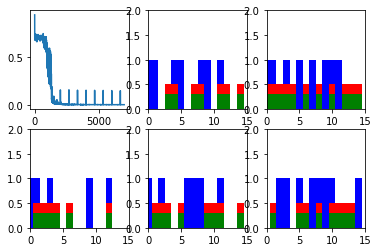

Step 400 Loss 0.00054800085 Time Taken 6.08868503571


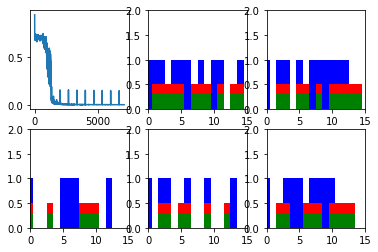

Step 500 Loss 0.0006577723 Time Taken 7.58509206772


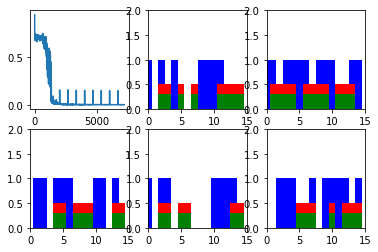

Step 600 Loss 0.00053891743 Time Taken 9.20776391029


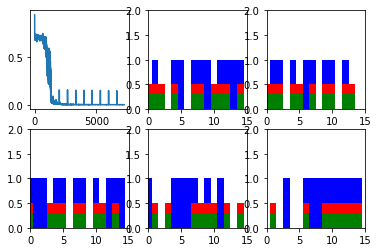

New Data epoch  11
Step 0 Loss 0.14473787 Time Taken 0.00231695175171


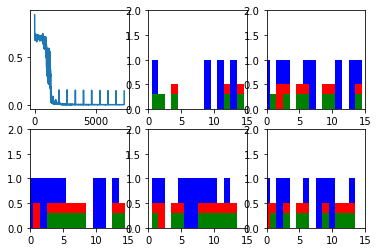

Step 100 Loss 0.00047976046 Time Taken 1.40131211281


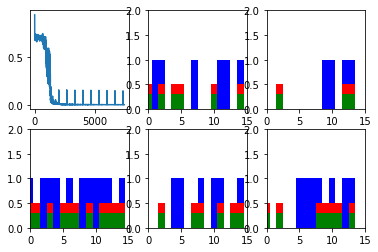

Step 200 Loss 0.00053928845 Time Taken 2.82010293007


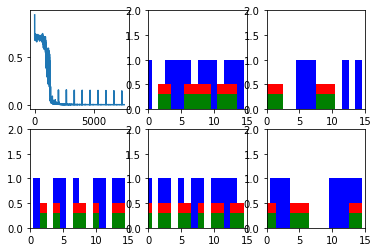

Step 300 Loss 0.00055387017 Time Taken 4.3480861187


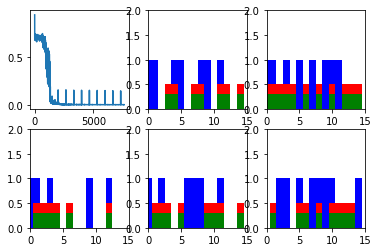

Step 400 Loss 0.00048774312 Time Taken 6.06150102615


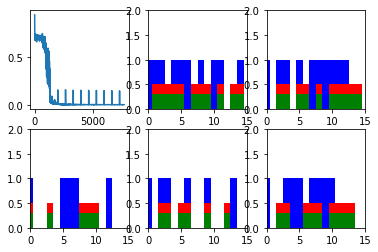

Step 500 Loss 0.00059146085 Time Taken 7.51129698753


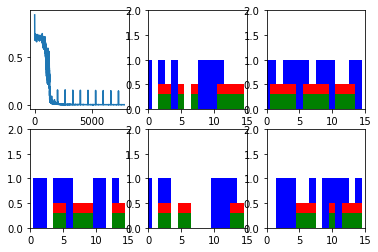

Step 600 Loss 0.00048357647 Time Taken 8.83653092384


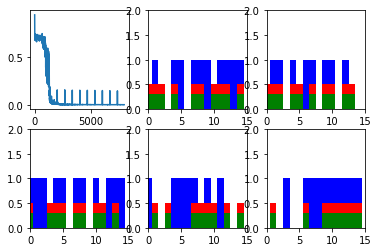

New Data epoch  12
Step 0 Loss 0.14297177 Time Taken 0.00206112861633


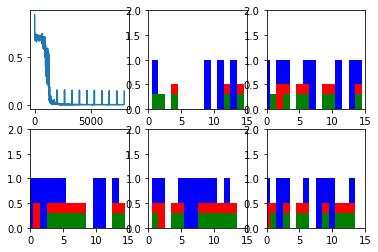

Step 100 Loss 0.0004330276 Time Taken 1.30447006226


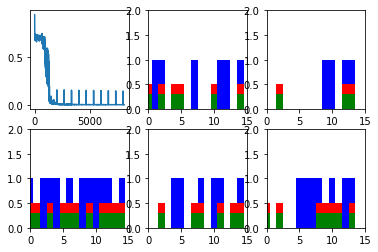

Step 200 Loss 0.0004816773 Time Taken 2.59700703621


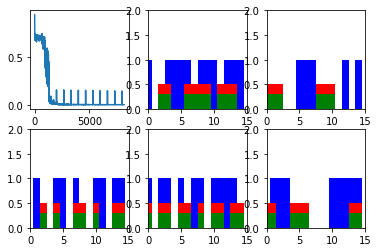

Step 300 Loss 0.0005009038 Time Taken 4.31485009193


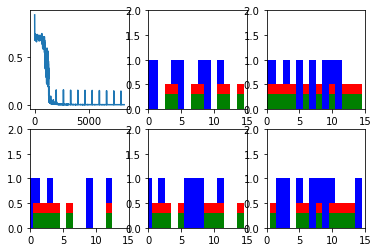

Step 400 Loss 0.0004394569 Time Taken 5.84421110153


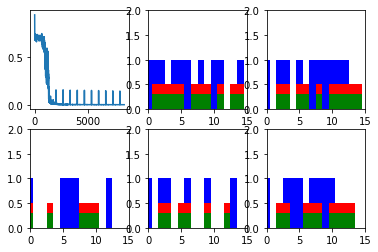

Step 500 Loss 0.0005374502 Time Taken 7.51287198067


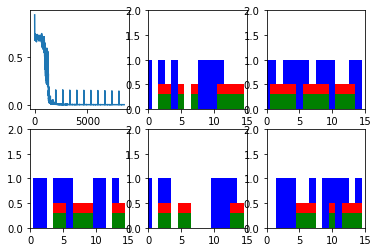

Step 600 Loss 0.00043837551 Time Taken 9.10391998291


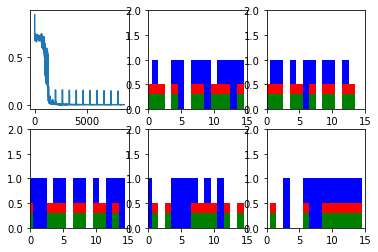

New Data epoch  13
Step 0 Loss 0.1411533 Time Taken 0.0022120475769


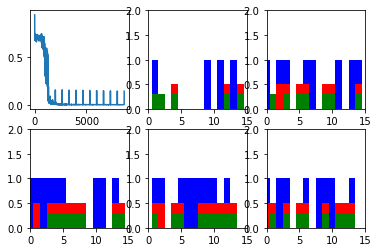

Step 100 Loss 0.00039492451 Time Taken 1.51545095444


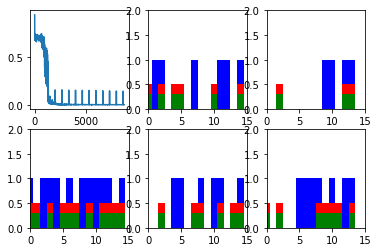

Step 200 Loss 0.0004352353 Time Taken 3.06506204605


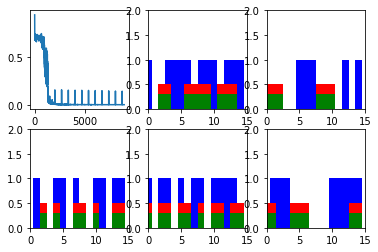

Step 300 Loss 0.0004573279 Time Taken 4.73410511017


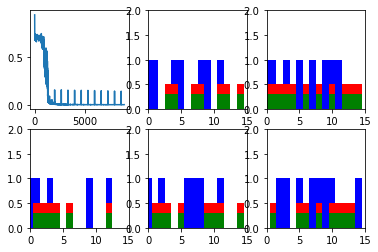

Step 400 Loss 0.00039993878 Time Taken 6.51597094536


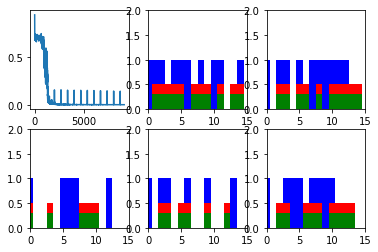

Step 500 Loss 0.0004926072 Time Taken 8.2111620903


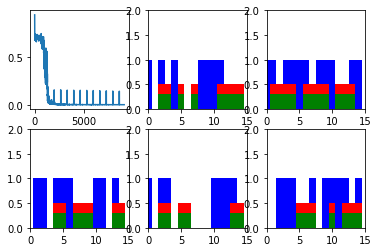

Step 600 Loss 0.0004007666 Time Taken 9.93021702766


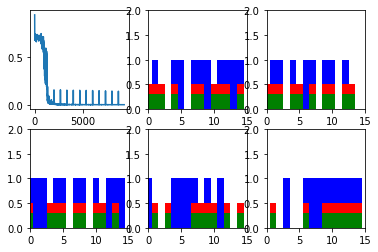

New Data epoch  14
Step 0 Loss 0.13931365 Time Taken 0.00214695930481


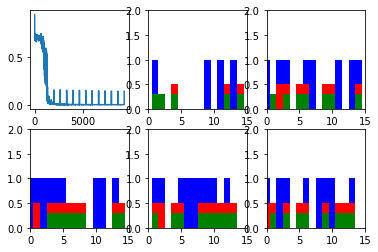

Step 100 Loss 0.00036327698 Time Taken 1.64176702499


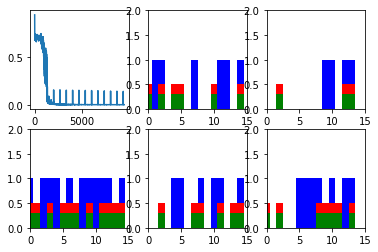

Step 200 Loss 0.0003970598 Time Taken 3.28919506073


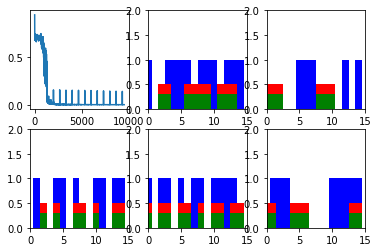

Step 300 Loss 0.0004208445 Time Taken 4.71222400665


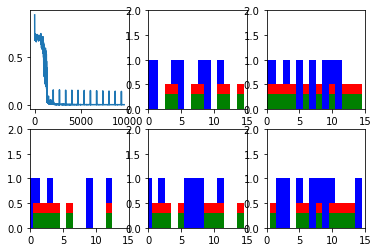

Step 400 Loss 0.0003670226 Time Taken 6.11711716652


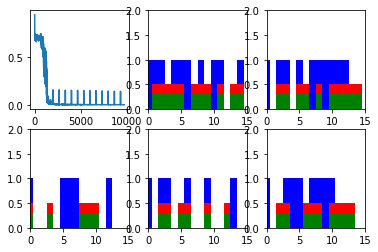

Step 500 Loss 0.0004547152 Time Taken 7.72715115547


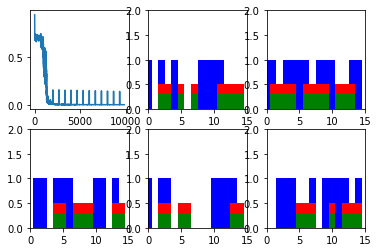

Step 600 Loss 0.0003689247 Time Taken 9.38576006889


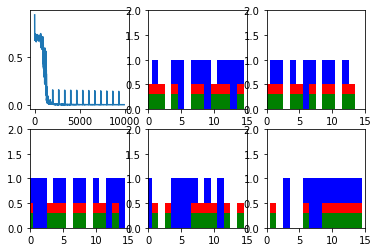

New Data epoch  15
Step 0 Loss 0.13748014 Time Taken 0.00210404396057


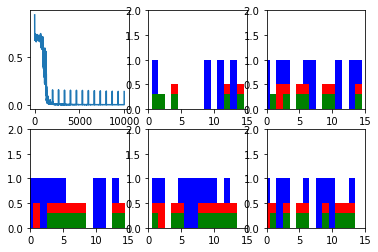

Step 100 Loss 0.00033656924 Time Taken 1.81114220619


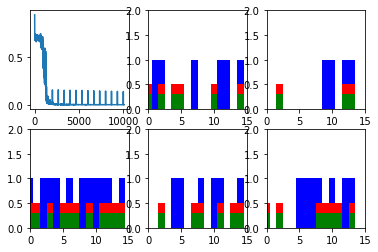

Step 200 Loss 0.00036493927 Time Taken 3.44874310493


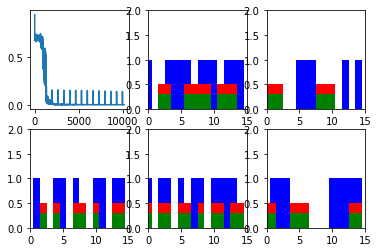

Step 300 Loss 0.00038981394 Time Taken 4.77478313446


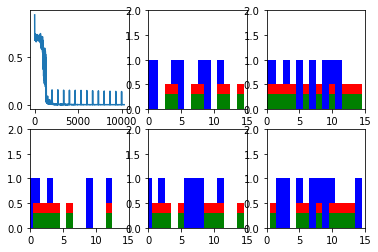

Step 400 Loss 0.0003391765 Time Taken 6.26539301872


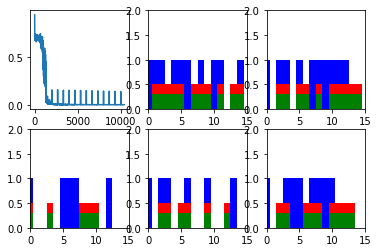

Step 500 Loss 0.00042236995 Time Taken 7.7973151207


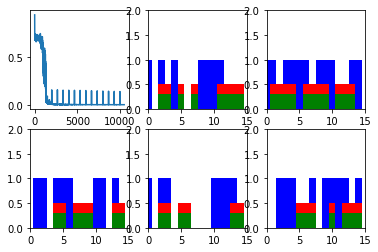

Step 600 Loss 0.0003417043 Time Taken 9.3623790741


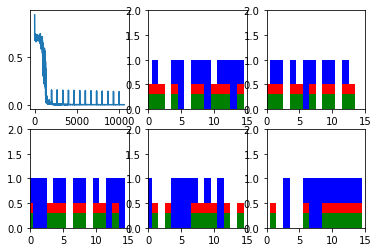

New Data epoch  16
Step 0 Loss 0.13567418 Time Taken 0.00190305709839


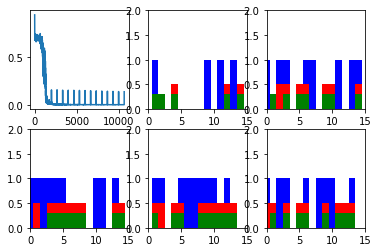

Step 100 Loss 0.00031363618 Time Taken 1.52502894402


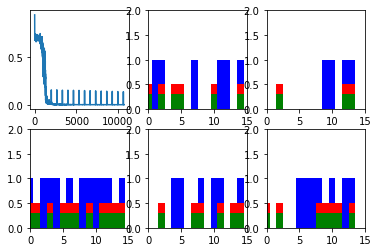

Step 200 Loss 0.00033791692 Time Taken 2.96915102005


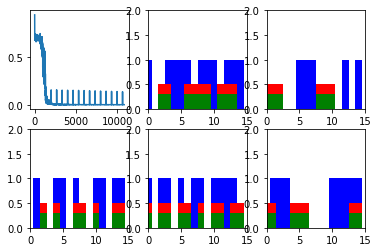

Step 300 Loss 0.0003631441 Time Taken 4.4898660183


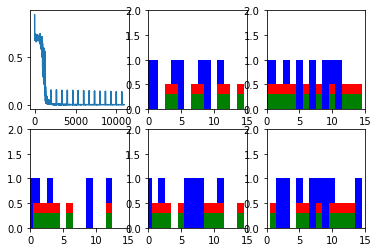

Step 400 Loss 0.00031525313 Time Taken 6.03687095642


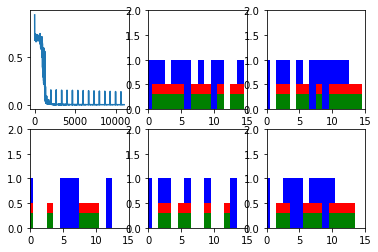

Step 500 Loss 0.00039407975 Time Taken 7.52961587906


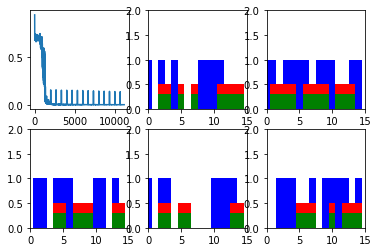

Step 600 Loss 0.0003178574 Time Taken 8.94883584976


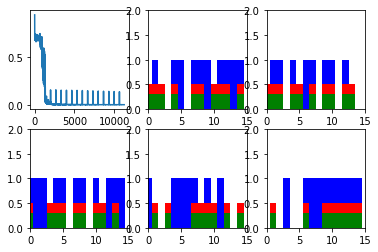

New Data epoch  17
Step 0 Loss 0.13392912 Time Taken 0.00402593612671


KeyboardInterrupt: 

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # interactive mode 
    plt.ion()
    
    # plot figure
    plt.figure()
    
    # show plot
    plt.show()
    
    # empty loss list
    loss_list = []
    
    for epoch_idx in xrange(NUM_EPOCHS):
        
        x,y = generateData()
        
        _current_state = np.zeros((BATCH_SIZE, STATE_SIZE))
        
        print("New Data epoch ", epoch_idx)
        # each batch 
        start = time.time()
        for batch_idx in range(NUM_BATCHES):
            start_idx = batch_idx * TRUNCATED_BACKPROP_LENGTH
            end_idx = start_idx + TRUNCATED_BACKPROP_LENGTH
            
            batchX = x[:, start_idx:end_idx]
            batchY = y[:, start_idx:end_idx]
            
            # time to calculate total loss 
            _total_loss, _train_step, _current_state, _prediction_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict = {
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                }
            )
            
            loss_list.append(_total_loss)
            
            if batch_idx % 100 == 0:
                print("Step",batch_idx, "Loss", _total_loss, "Time Taken", (time.time() - start))
                plot(loss_list, _prediction_series, batchX, batchY)
plt.ioff()
plt.show()